In [1]:
from underlying import Underlying
from option import Option, Vanilla
from trader import Trader

import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
from quantile_hedging_calculator import *
import numpy as np
import pandas as pd

In [2]:
mu = 0.06
sigma =  0.2
r = 0.05
T = 1
X0 = 100
repeat = 1000
values_per_year = 250

## Full hedging - Vanilla Call

In [3]:
K = 80

In [4]:
underlying = Underlying(mu, sigma, r, values_per_year)

In [5]:
_, reality = underlying.simulate_P(repeat, T)

In [6]:
vanilla_call = Vanilla(underlying, K, T, True)

In [7]:
BS_price_call = vanilla_call.get_price(X0, 0)
BS_price_call

24.58883544392775

In [8]:
money_time_call = pd.DataFrame(np.zeros(reality.shape))
delta_time_call = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = BS_price_call)
    money, delta, _ = trader.simulate_hedging(vanilla_call, X0*reality.iloc[[i],:], update_freq = 1)
    money_time_call.loc[i] = money
    delta_time_call.loc[i] = delta

100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.71it/s]


Text(0.5, 1.0, 'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = -0.005, std = 0.217')

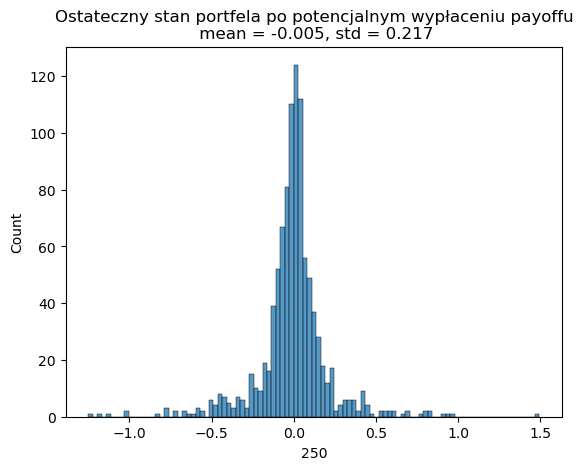

In [9]:
sb.histplot(money_time_call.iloc[:,-1]).set_title(f'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

## Full hedging - Vanilla Put

In [10]:
K = 120

In [11]:
underlying = Underlying(mu, sigma, r, values_per_year)

In [12]:
_, reality = underlying.simulate_P(repeat, T)

In [13]:
vanilla_put = Vanilla(underlying, K, T, False)

In [14]:
BS_price_put = vanilla_put.get_price(X0, 0)
BS_price_put

17.3950083566465

In [15]:
money_time_put = pd.DataFrame(np.zeros(reality.shape))
delta_time_put = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = BS_price_put)
    money, delta, _ = trader.simulate_hedging(vanilla_put, X0*reality.iloc[[i],:], update_freq = 1)
    money_time_put.loc[i] = money
    delta_time_put.loc[i] = delta

100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.50it/s]


Text(0.5, 1.0, 'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = 0.008, std = 0.439')

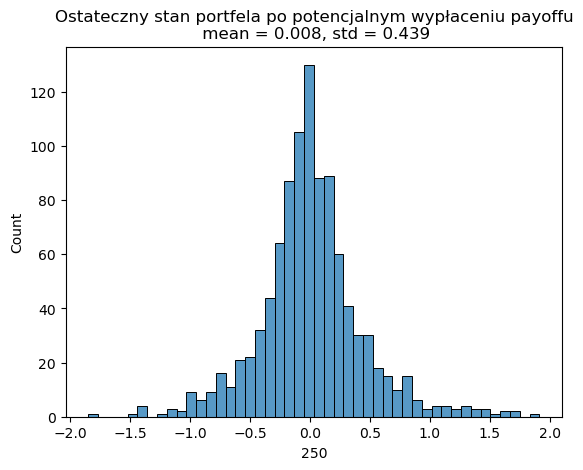

In [16]:
sb.histplot(money_time_put.iloc[:,-1]).set_title(f'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

## Quantile hedging with half of required initial capital- Vanilla Call

In [17]:
K = 80

In [18]:
underlying = Underlying(mu, sigma, r, values_per_year)

In [19]:
_, reality = underlying.simulate_P(repeat, T)

In [20]:
V0 = BS_price_call / 2

In [21]:
money_time_call_full = pd.DataFrame(np.zeros(reality.shape))
delta_time_call_full = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = V0)
    money, delta, _ = trader.simulate_hedging(vanilla_call, X0*reality.iloc[[i],:], update_freq = 1)
    money_time_call_full.loc[i] = money
    delta_time_call_full.loc[i] = delta

100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 21.88it/s]


In [22]:
vanilla_call = Vanilla(underlying, K, T, True)

In [23]:
money_time_call = pd.DataFrame(np.zeros(reality.shape))
delta_time_call = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = V0)
    money, delta, objective_func = trader.simulate_hedging(vanilla_call, X0*reality.iloc[[i],:], update_freq = 1, limited_capital = True)
    money_time_call.loc[i] = money
    delta_time_call.loc[i] = delta
print(f'Success probability with initial capital={V0:.2f} is: {objective_func[0]:.4f}')
print(f'Success ratio with initial capital={V0:.2f} is: {objective_func[1]:.4f}')

100%|███████████████████████████████████████| 1000/1000 [05:22<00:00,  3.10it/s]

Success probability with initial capital=12.29 is: 0.6452
Success ratio with initial capital=12.29 is: 0.8747


(0.0, 250.0)

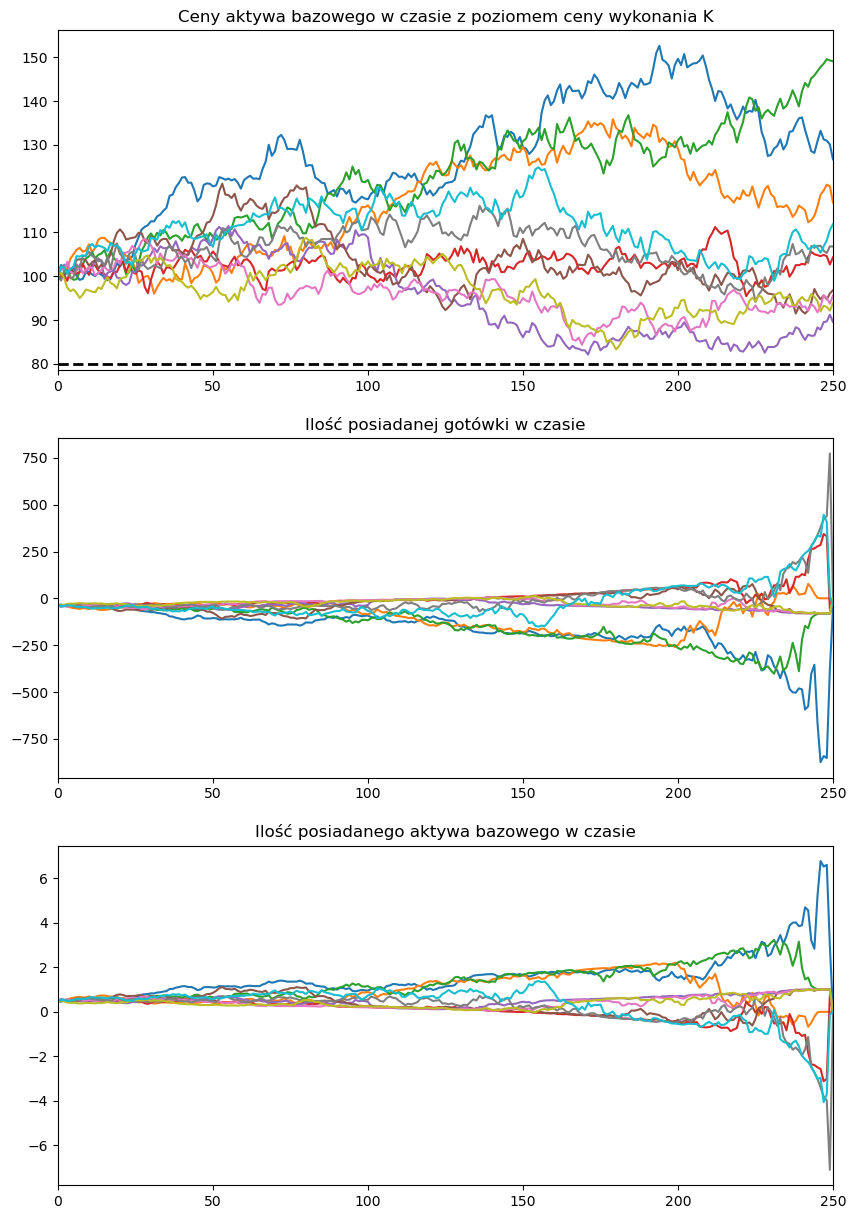

In [24]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0*reality.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

[(-60.29968567213547, 15.143444899689925),
 Text(0.5, 1.0, 'Dopasowany do V0 hedging kwantylowy\n mean = -13.130, std = 17.794')]

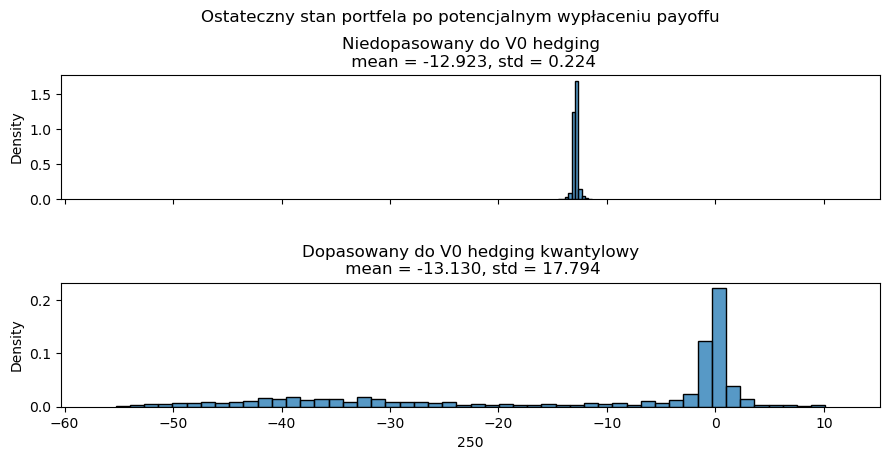

In [25]:
fig, axs = plt.subplots(2, 1, figsize = (10, 5), sharex = True)
fig.tight_layout(pad=5.0)
plt.suptitle('Ostateczny stan portfela po potencjalnym wypłaceniu payoffu')
sb.histplot(money_time_call_full.iloc[:,-1], ax = axs[0], bins = 10, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Niedopasowany do V0 hedging\n mean = {money_time_call_full.iloc[:,-1].mean():.3f}, std = {money_time_call_full.iloc[:,-1].std():.3f}')
sb.histplot(money_time_call.iloc[:,-1], ax = axs[1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

Text(0.5, 1.0, 'Ostateczny stan portfela- wszystkie symulacje')

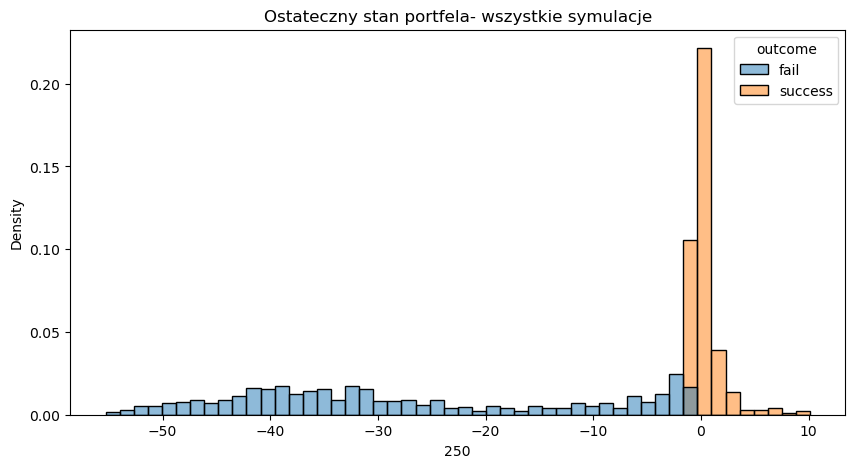

In [26]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying.values_per_year * T], bins = 50, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [27]:
money_time_call_outcome[['outcome',underlying.values_per_year * T]].groupby('outcome').describe()

250                                                         \
         count       mean        std        min        25%        50%   
outcome                                                                 
fail     486.0 -27.430909  15.848286 -55.299686 -39.920154 -31.617871   
success  514.0   0.392414   1.480952  -1.224678  -0.359368   0.062315   

                               
               75%        max  
outcome                        
fail    -11.643344  -1.230043  
success   0.694014  10.143445

Text(0.5, 1.0, 'Ostateczny payoff opcji (wszystkie symulacje)- histogram')

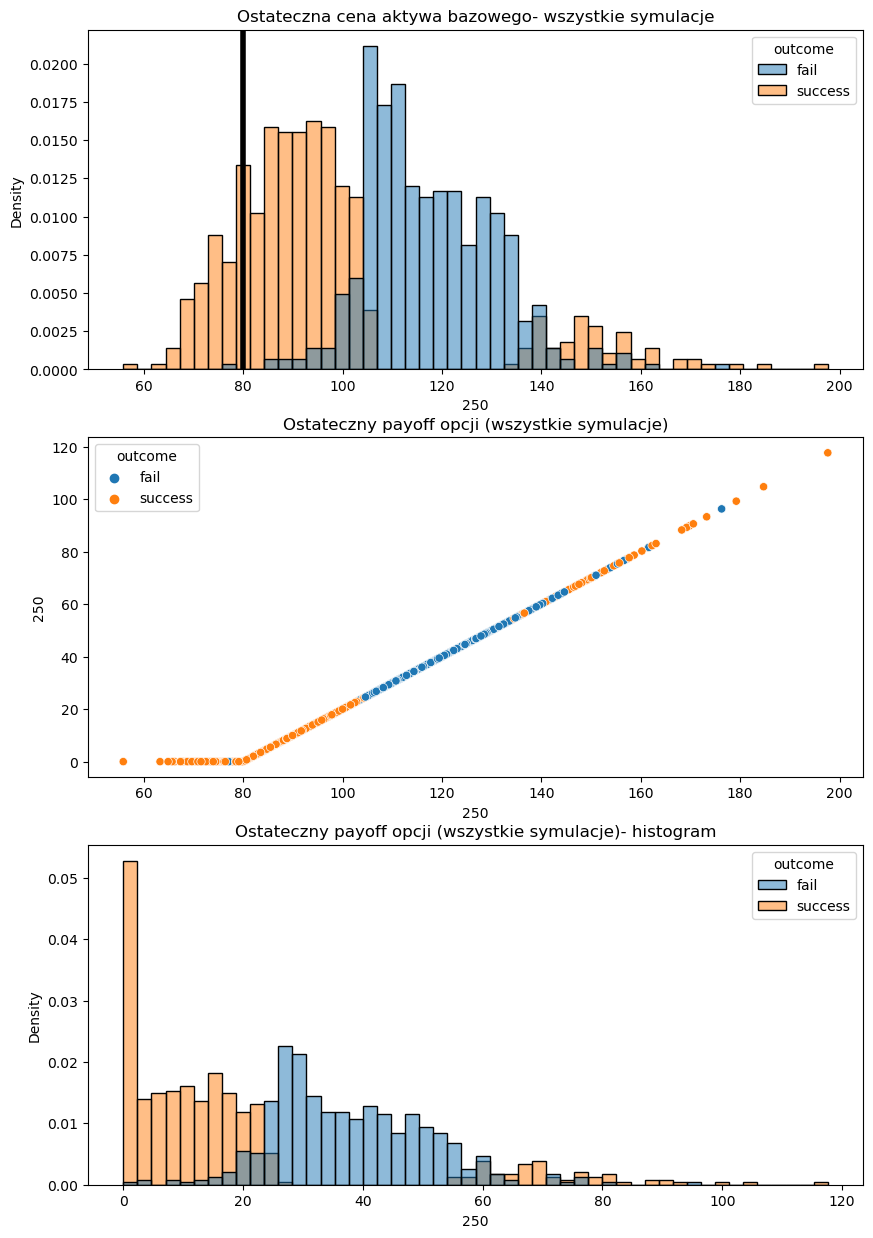

In [28]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
sb.histplot(ax = axs[0], x = (X0*reality)[underlying.values_per_year * T], hue = money_time_call_outcome['outcome'], bins = 50, stat = 'density').set_title('Ostateczna cena aktywa bazowego- wszystkie symulacje')
axs[0].axvline(K, color = 'black', lw = 4)
sb.scatterplot(ax = axs[1], x = (X0*reality).iloc[:,-1], y = np.maximum((X0*reality)[underlying.values_per_year * T] - K,0), hue = money_time_call_outcome['outcome']).set_title('Ostateczny payoff opcji (wszystkie symulacje)')
sb.histplot(ax = axs[2], x = np.maximum((X0*reality)[underlying.values_per_year * T] - K,0), hue = money_time_call_outcome['outcome'], bins = 50, stat = 'density').set_title('Ostateczny payoff opcji (wszystkie symulacje)- histogram')

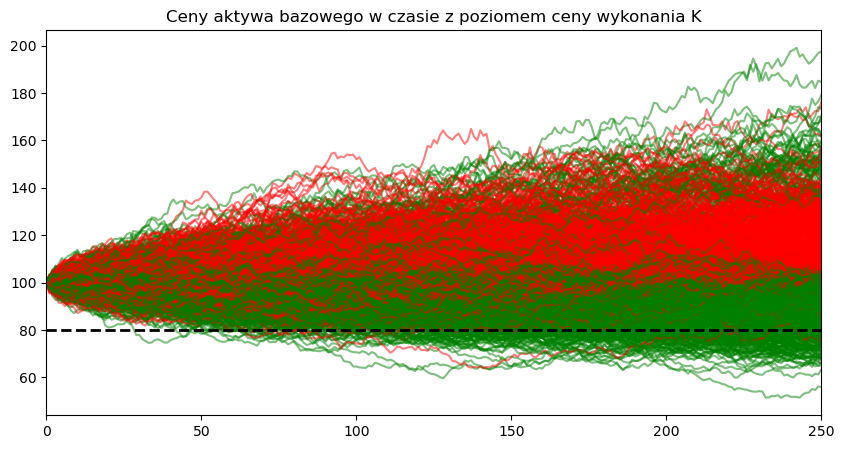

In [29]:
fig, axs = plt.subplots(1, 1, figsize = (10, 5))
(X0*reality).T.plot.line(ax = axs, alpha = 0.5, legend = False, color = money_time_call_outcome.apply(lambda row: 'green' if row['outcome'] == 'success' else 'red', axis = 1), title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs.set_xlim([0,values_per_year])
axs.axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)

## Quantile hedging with half of required initial capital- Vanilla Put

In [30]:
K = 120

In [31]:
underlying = Underlying(mu, sigma, r, values_per_year)

In [32]:
_, reality = underlying.simulate_P(repeat, T)

In [33]:
V0 = BS_price_put / 2

In [34]:
money_time_put_full = pd.DataFrame(np.zeros(reality.shape))
delta_time_put_full = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = V0)
    money, delta, _ = trader.simulate_hedging(vanilla_put, X0*reality.iloc[[i],:], update_freq = 1)
    money_time_put_full.loc[i] = money
    delta_time_put_full.loc[i] = delta

100%|███████████████████████████████████████| 1000/1000 [00:48<00:00, 20.82it/s]


In [35]:
vanilla_put = Vanilla(underlying, K, T, False)

In [36]:
money_time_put = pd.DataFrame(np.zeros(reality.shape))
delta_time_put = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = V0)
    money, delta, objective_func = trader.simulate_hedging(vanilla_put, X0*reality.iloc[[i],:], update_freq = 1, limited_capital = True)
    money_time_put.loc[i] = money
    delta_time_put.loc[i] = delta
print(f'Success probability with initial capital={V0:.2f} is: {objective_func[0]:.4f}')
print(f'Success ratio with initial capital={V0:.2f} is: {objective_func[1]:.4f}')

100%|███████████████████████████████████████| 1000/1000 [05:30<00:00,  3.03it/s]

Success probability with initial capital=8.70 is: 0.7155
Success ratio with initial capital=8.70 is: 0.9127


(0.0, 250.0)

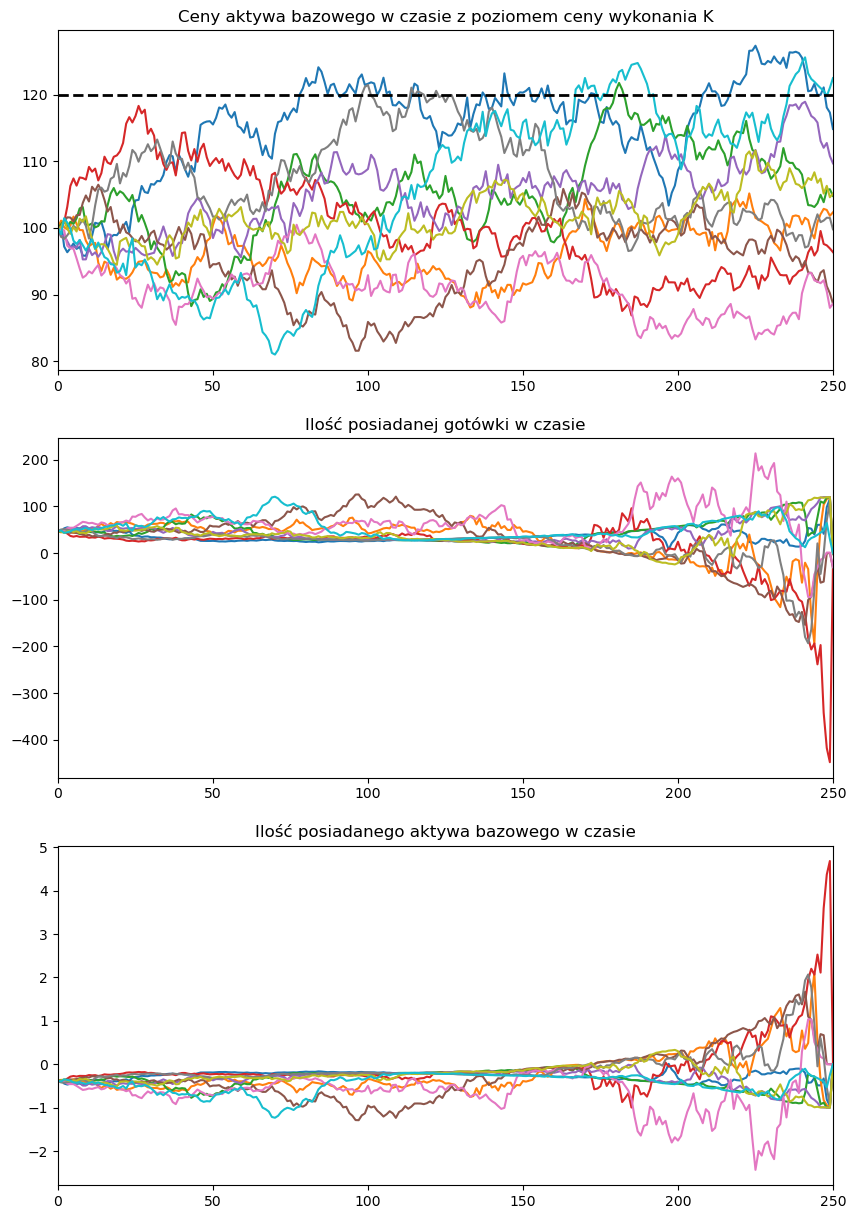

In [37]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0*reality.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

[(-52.14617141450405, 30.23187534272158),
 Text(0.5, 1.0, 'Dopasowany do V0 hedging kwantylowy\n mean = -8.210, std = 13.434')]

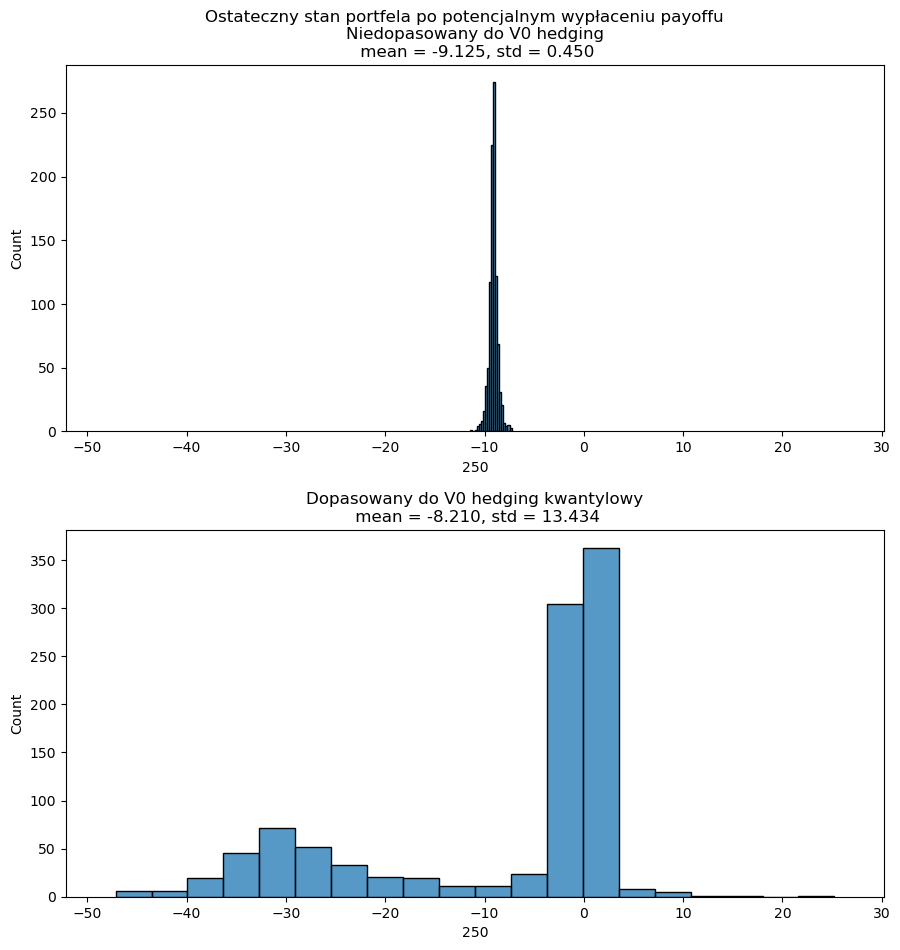

In [38]:
fig, axs = plt.subplots(2, 1, figsize = (10, 10))
fig.tight_layout(pad=5.0)
plt.suptitle('Ostateczny stan portfela po potencjalnym wypłaceniu payoffu')
sb.histplot(money_time_put_full.iloc[:,-1], ax = axs[0], bins = 20).set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Niedopasowany do V0 hedging\n mean = {money_time_put_full.iloc[:,-1].mean():.3f}, std = {money_time_put_full.iloc[:,-1].std():.3f}')
sb.histplot(money_time_put.iloc[:,-1], ax = axs[1], bins = 20).set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

Text(0.5, 1.0, 'Ostateczny stan portfela- wszystkie symulacje')

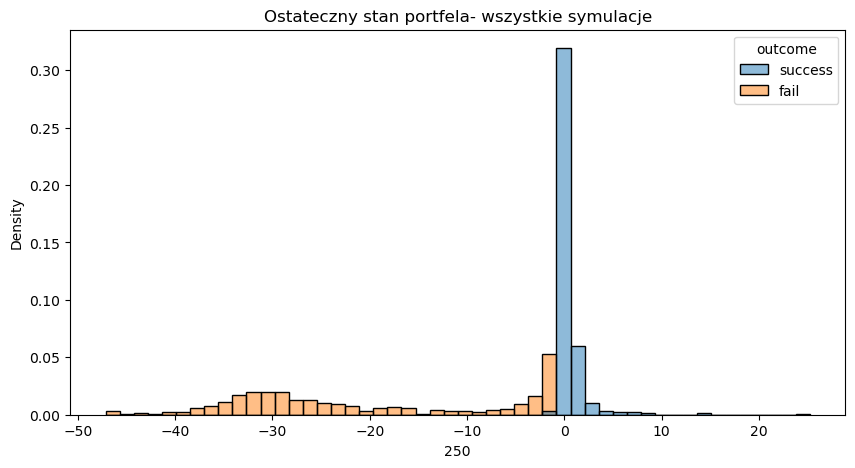

In [39]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying.values_per_year * T], bins = 50, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [40]:
money_time_put_outcome[['outcome',underlying.values_per_year * T]].groupby('outcome').describe()

250                                                         \
         count       mean        std        min        25%        50%   
outcome                                                                 
fail     416.0 -20.292272  13.408956 -47.146171 -31.208932 -25.127549   
success  584.0   0.396372   1.703783  -0.868046  -0.227911   0.092689   

                              
              75%        max  
outcome                       
fail    -4.099526  -0.882301  
success  0.500984  25.231875

Text(0.5, 1.0, 'Ostateczny payoff opcji (wszystkie symulacje)- histogram')

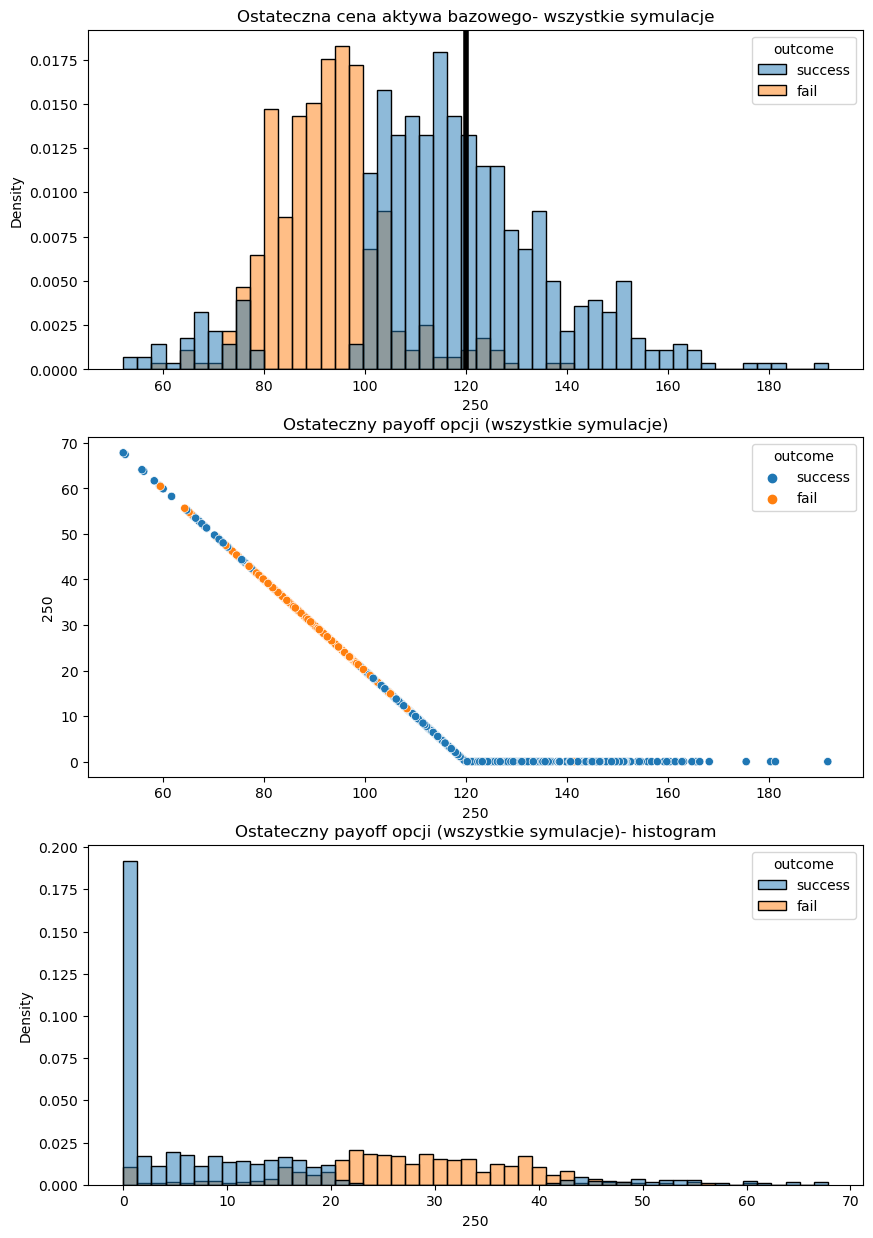

In [41]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
sb.histplot(ax = axs[0], x = (X0*reality)[underlying.values_per_year * T], hue = money_time_put_outcome['outcome'], bins = 50, stat = 'density').set_title('Ostateczna cena aktywa bazowego- wszystkie symulacje')
axs[0].axvline(K, color = 'black', lw = 4)
sb.scatterplot(ax = axs[1], x = (X0*reality).iloc[:,-1], y = np.maximum(K - (X0*reality)[underlying.values_per_year * T],0), hue = money_time_put_outcome['outcome']).set_title('Ostateczny payoff opcji (wszystkie symulacje)')
sb.histplot(ax = axs[2], x = np.maximum(K - (X0*reality)[underlying.values_per_year * T],0), hue = money_time_put_outcome['outcome'], bins = 50, stat = 'density').set_title('Ostateczny payoff opcji (wszystkie symulacje)- histogram')

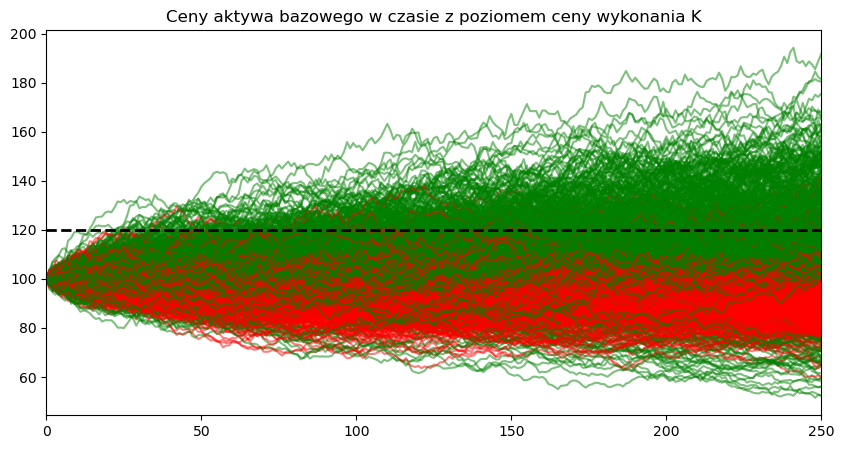

In [42]:
fig, axs = plt.subplots(1, 1, figsize = (10, 5))
(X0*reality).T.plot.line(ax = axs, alpha = 0.5, legend = False, color = money_time_put_outcome.apply(lambda row: 'green' if row['outcome'] == 'success' else 'red', axis = 1), title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs.set_xlim([0,values_per_year])
axs.axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)

## Tests on modified payoff properties

### Vanilla call

In [43]:
K = 80
vanilla_call = Vanilla(underlying, K, T, True)

In [44]:
payoff_func_v0, objective_func, cs = payoff_from_v0(vanilla_call, BS_price_call/2, X0)
print(f'Success prob for V0={BS_price_call/2:.2f}: {objective_func[0]:.5f}')
print(f'Success ratio for V0={BS_price_call/2:.2f}: {objective_func[1]:.5f}')
payoff_func_prob, success_V0, _ = payoff_from_prob(vanilla_call, objective_func[0], X0)
print(f'Proper V0 for success prob={objective_func[0]:.2f}: {success_V0:.2f}')

Success prob for V0=12.29: 0.65210
Success ratio for V0=12.29: 0.87627
Proper V0 for success prob=0.65: 12.39


In [45]:
W, X = vanilla_call.underlying.simulate_P(10000, T=vanilla_call.T)

Text(0.5, 0.98, "Simulations final value and option's modified payoffs together with K and c boundaries")

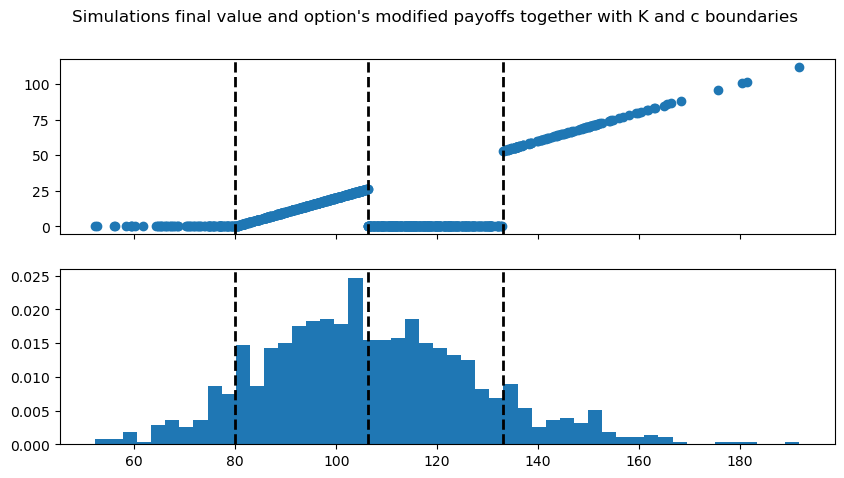

In [46]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (10, 5))
axs[0].scatter(X0*reality.iloc[:,-1], payoff_func_v0(X0*reality))
axs[0].axvline(K, color = 'black', linestyle = '--', lw = 2)
for c in cs:
    if c > 0:
        axs[0].axvline(c, color = 'black', linestyle = '--', lw = 2)
axs[1].hist(X0*reality.iloc[:,-1], bins = 50, density = True)
axs[1].axvline(K, color = 'black', linestyle = '--', lw = 2)
for c in cs:
    if c > 0:
        axs[1].axvline(c, color = 'black', linestyle = '--', lw = 2)
plt.suptitle("Simulations final value and option's modified payoffs together with K and c boundaries")

### Vanilla put

In [47]:
K = 120
vanilla_put = Vanilla(underlying, K, T, False)

In [48]:
payoff_func_v0, objective_func, cs = payoff_from_v0(vanilla_put, BS_price_put/2, X0)
print(f'Success prob for V0={BS_price_put/2:.2f}: {objective_func[0]:.5f}')
print(f'Success ratio for V0={BS_price_put/2:.2f}: {objective_func[1]:.5f}')
payoff_func_prob, success_V0, _ = payoff_from_prob(vanilla_put, objective_func[0], X0)
print(f'Proper V0 for success prob={objective_func[0]:.2f}: {success_V0:.2f}')

Success prob for V0=8.70: 0.69940
Success ratio for V0=8.70: 0.90673
Proper V0 for success prob=0.70: 8.16


Text(0.5, 0.98, "Simulations final value and option's modified payoffs together with K and c boundaries")

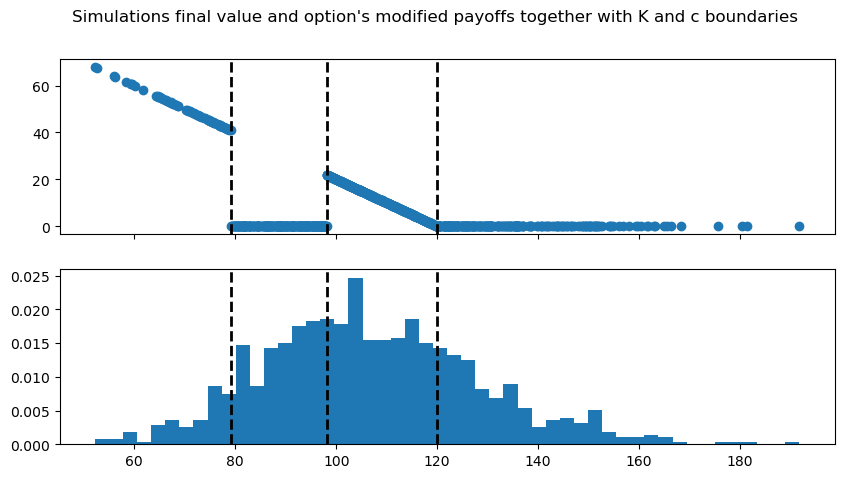

In [49]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (10, 5))
axs[0].scatter(X0*reality.iloc[:,-1], payoff_func_v0(X0*reality))
axs[0].axvline(K, color = 'black', linestyle = '--', lw = 2)
for c in cs:
    if c > 0:
        axs[0].axvline(c, color = 'black', linestyle = '--', lw = 2)
axs[1].hist(X0*reality.iloc[:,-1], bins = 50, density = True)
axs[1].axvline(K, color = 'black', linestyle = '--', lw = 2)
for c in cs:
    if c > 0:
        axs[1].axvline(c, color = 'black', linestyle = '--', lw = 2)
plt.suptitle("Simulations final value and option's modified payoffs together with K and c boundaries")

## Sensivity analysis on $\alpha$ vs success probability

### Vanilla call

4it [00:54, 13.72s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla call\nalpha level vs objective functions values')

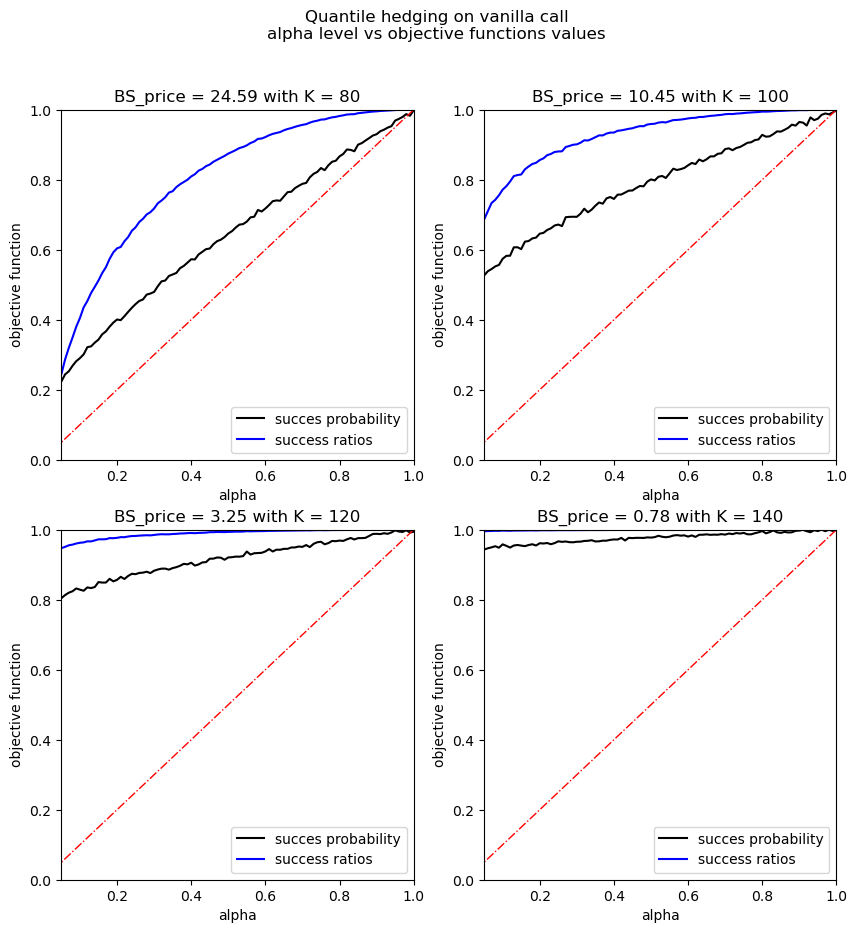

In [50]:
Ks = [80, 100, 120, 140]
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for num, K in tqdm(enumerate(Ks)):
    vanilla_call = Vanilla(underlying, K, T, True)
    BS_price = vanilla_call.get_price(X0, 0)
    alphas = np.arange(5,101,1)/100
    probs = []
    ratios = []
    for a in alphas:
        _, objective_func, _ = payoff_from_v0(vanilla_call, a * BS_price, X0)
        probs.append(objective_func[0])
        ratios.append(objective_func[1])
    axs[num//2, num%2].plot(alphas, probs, color = 'black')
    axs[num//2, num%2].plot(alphas, ratios, color = 'blue')
    axs[num//2, num%2].legend(['succes probability', 'success ratios'])
    axs[num//2, num%2].plot([0,1],[0,1], color = 'red', lw = 1, linestyle='-.')
    axs[num//2, num%2].set_title(f'BS_price = {BS_price:.2f} with K = {K}')
    axs[num//2, num%2].set_xlabel('alpha')
    axs[num//2, num%2].set_ylabel('objective function')
    axs[num//2, num%2].set_xlim([0.05,1])
    axs[num//2, num%2].set_ylim([0,1])
plt.suptitle('Quantile hedging on vanilla call\nalpha level vs objective functions values')

4it [21:00, 315.08s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla call\nfinal simulation values')

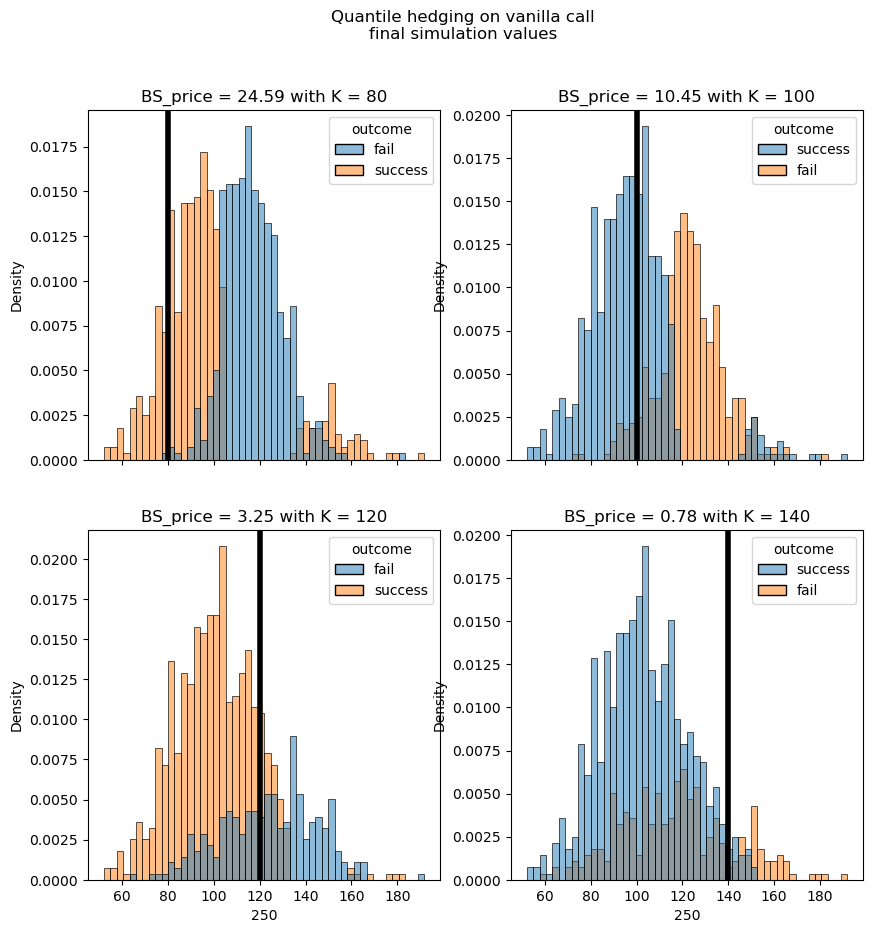

In [51]:
Ks = [80, 100, 120, 140]
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex = True)
for num, K in tqdm(enumerate(Ks)):
    vanilla_call = Vanilla(underlying, K, T, True)
    BS_price = vanilla_call.get_price(X0, 0)
    V0 = 0.5 * BS_price
    money_time_call = pd.DataFrame(np.zeros(reality.shape))
    delta_time_call = pd.DataFrame(np.zeros(reality.shape))
    for i in range(repeat):
        trader = Trader(initial_capital = V0)
        money, delta, _ = trader.simulate_hedging(vanilla_call, X0*reality.iloc[[i],:], update_freq = 1, limited_capital = True)
        money_time_call.loc[i] = money
        delta_time_call.loc[i] = delta
    money_time_call_outcome = money_time_call.copy()
    money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
    sb.histplot(ax = axs[num//2, num%2], x = (X0*reality)[underlying.values_per_year * T], hue = money_time_call_outcome['outcome'], bins = 50, stat = 'density').set_title(f'BS_price = {BS_price:.2f} with K = {K}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla call\nfinal simulation values')

8it [00:02,  3.57it/s]


Text(0.5, 0.98, 'Quantile hedging on vanilla call\nmodified payoff')

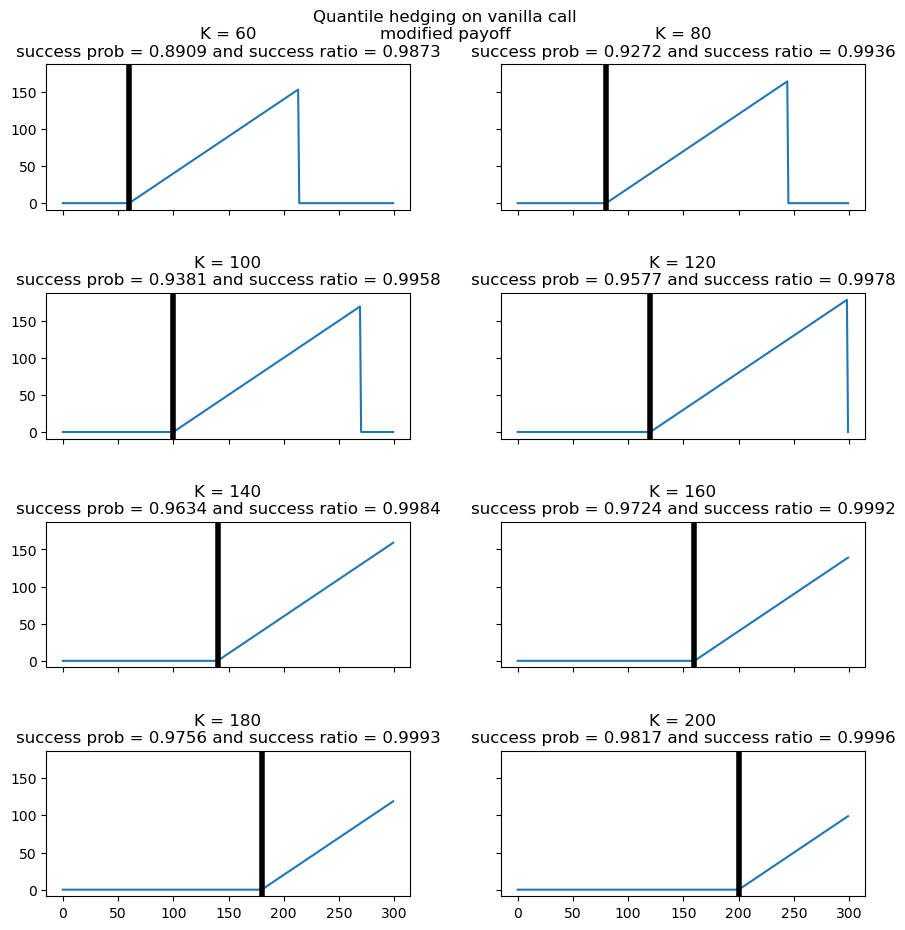

In [64]:
Ks = [60, 80, 100, 120, 140, 160, 180, 200]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex = True, sharey = True)
fig.tight_layout(pad=5.0)
for num, K in tqdm(enumerate(Ks)):
    vanilla_call = Vanilla(underlying, K, T, True)
    BS_price = vanilla_call.get_price(X0, 0)
    V0 = 0.5 * BS_price
    payoff_func, objective_func, _ = payoff_from_v0(vanilla_call, V0, X0)
    axs[num//2, num%2].plot(X, payoff_func(X))
    axs[num//2, num%2].set_title(f'K = {K}\nsuccess prob = {objective_func[0]:.4f} and success ratio = {objective_func[1]:.4f}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla call\nmodified payoff')

8it [00:02,  3.61it/s]


Text(0.5, 0.98, 'Quantile hedging on vanilla call\nmodified payoff')

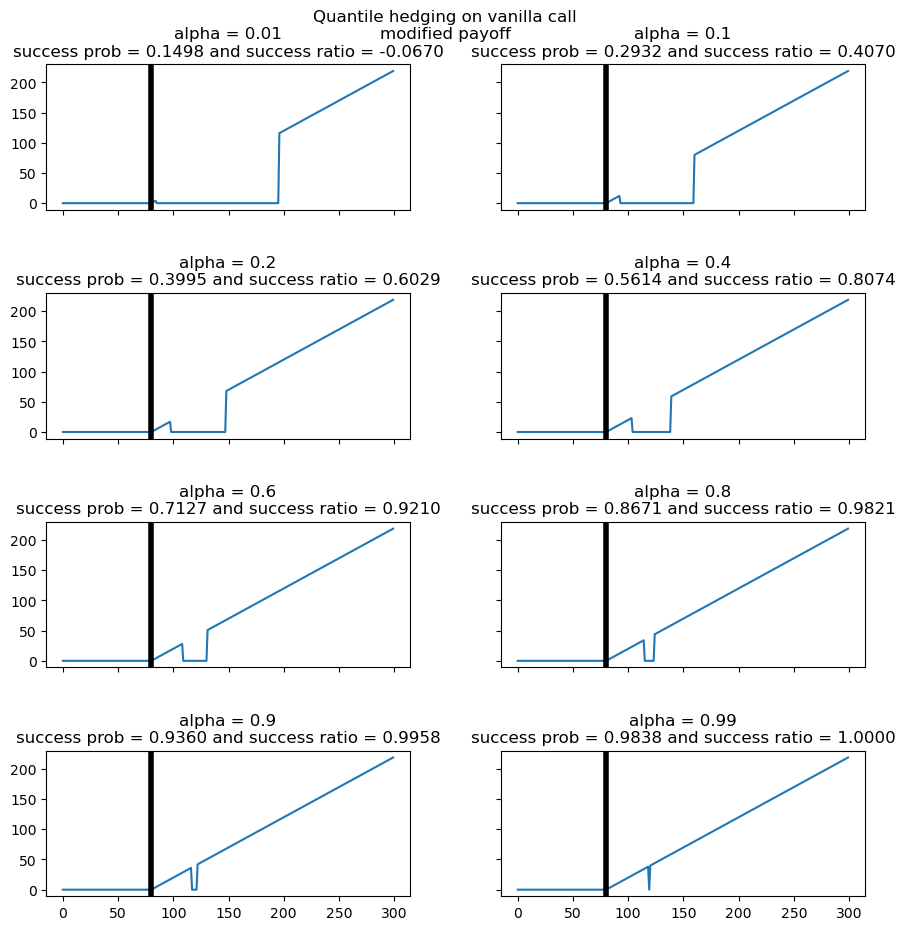

In [53]:
alphas = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex = True, sharey = True)
fig.tight_layout(pad=5.0)
for num, a in tqdm(enumerate(alphas)):
    vanilla_call = Vanilla(underlying, 80, T, True)
    BS_price = vanilla_call.get_price(X0, 0)
    V0 = a * BS_price
    payoff_func, objective_func, _ = payoff_from_v0(vanilla_call, V0, X0)
    axs[num//2, num%2].plot(X, payoff_func(X))
    axs[num//2, num%2].set_title(f'alpha = {a}\nsuccess prob = {objective_func[0]:.4f} and success ratio = {objective_func[1]:.4f}')
    axs[num//2, num%2].axvline(80, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla call\nmodified payoff')

8it [00:02,  3.69it/s]


Text(0.5, 0.98, 'Quantile hedging on vanilla call\nmodified payoff')

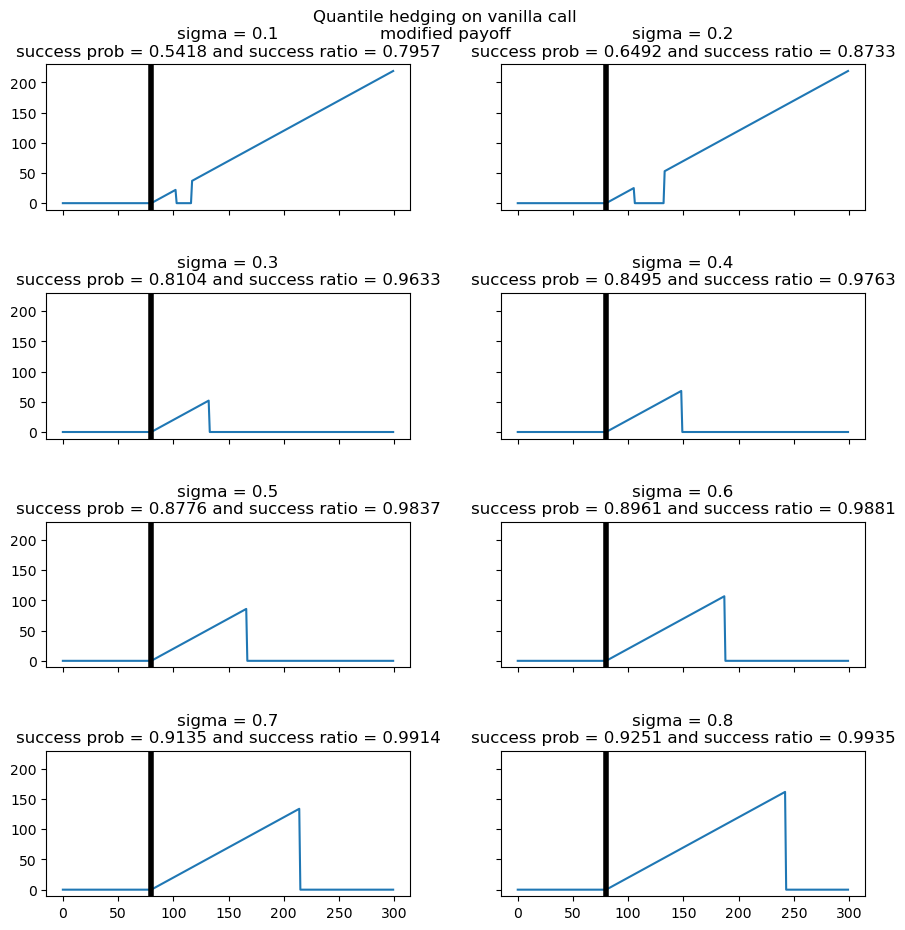

In [63]:
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex = True, sharey = True)
fig.tight_layout(pad=5.0)
for num, s in tqdm(enumerate(sigmas)):
    underlying = Underlying(mu, s, r, values_per_year)
    vanilla_call = Vanilla(underlying, 80, T, True)
    BS_price = vanilla_call.get_price(X0, 0)
    V0 = BS_price / 2
    payoff_func, objective_func, _ = payoff_from_v0(vanilla_call, V0, X0)
    axs[num//2, num%2].plot(X, payoff_func(X))
    axs[num//2, num%2].set_title(f'sigma = {s}\nsuccess prob = {objective_func[0]:.4f} and success ratio = {objective_func[1]:.4f}')
    axs[num//2, num%2].axvline(80, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla call\nmodified payoff')

### Vanilla put

In [55]:
underlying = Underlying(mu, sigma, r, values_per_year)

4it [00:54, 13.52s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla put\nalpha level vs objective functions values')

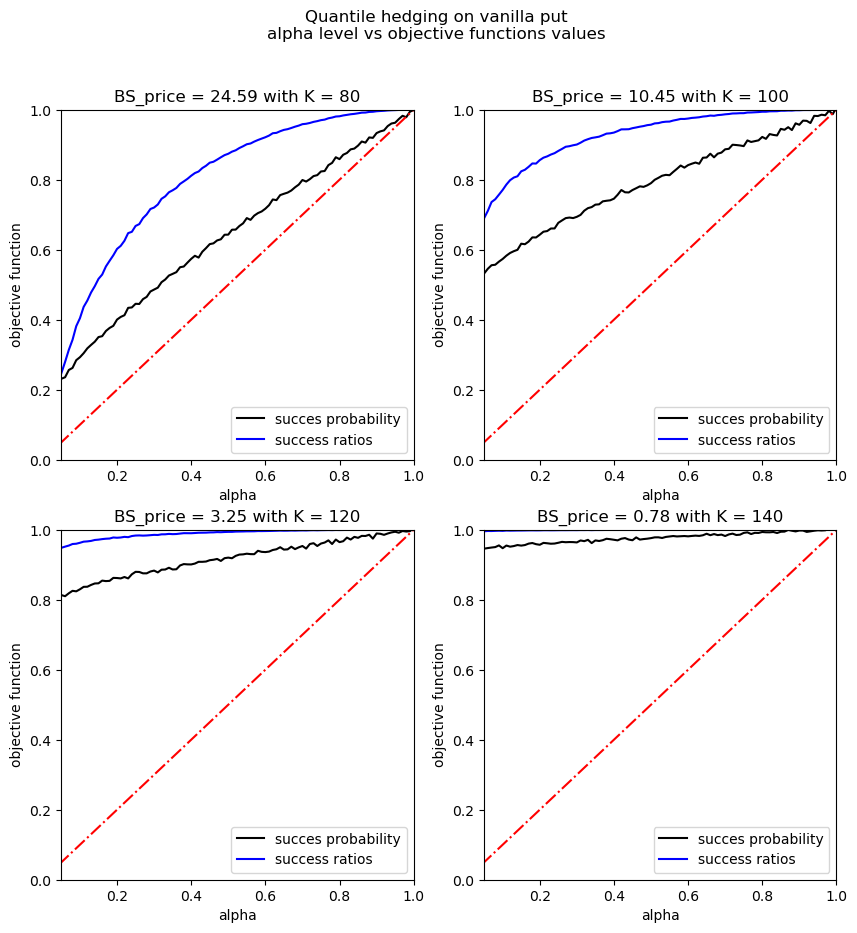

In [56]:
Ks = [80, 100, 120, 140]
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for num, K in tqdm(enumerate(Ks)):
    vanilla_put = Vanilla(underlying, K, T, True)
    BS_price = vanilla_put.get_price(X0, 0)
    alphas = np.arange(5,101,1)/100
    probs = []
    ratios = []
    for a in alphas:
        _, objective_func, _ = payoff_from_v0(vanilla_put, a * BS_price, X0)
        probs.append(objective_func[0])
        ratios.append(objective_func[1])
    axs[num//2, num%2].plot(alphas, probs, color = 'black')
    axs[num//2, num%2].plot(alphas, ratios, color = 'blue')
    axs[num//2, num%2].legend(['succes probability', 'success ratios'])
    axs[num//2, num%2].plot([0,1],[0,1], color = 'red', linestyle='-.')
    axs[num//2, num%2].set_title(f'BS_price = {BS_price:.2f} with K = {K}')
    axs[num//2, num%2].set_xlabel('alpha')
    axs[num//2, num%2].set_ylabel('objective function')
    axs[num//2, num%2].set_xlim([0.05,1])
    axs[num//2, num%2].set_ylim([0,1])
plt.suptitle('Quantile hedging on vanilla put\nalpha level vs objective functions values')

4it [20:01, 300.37s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla put\nfinal simulation values')

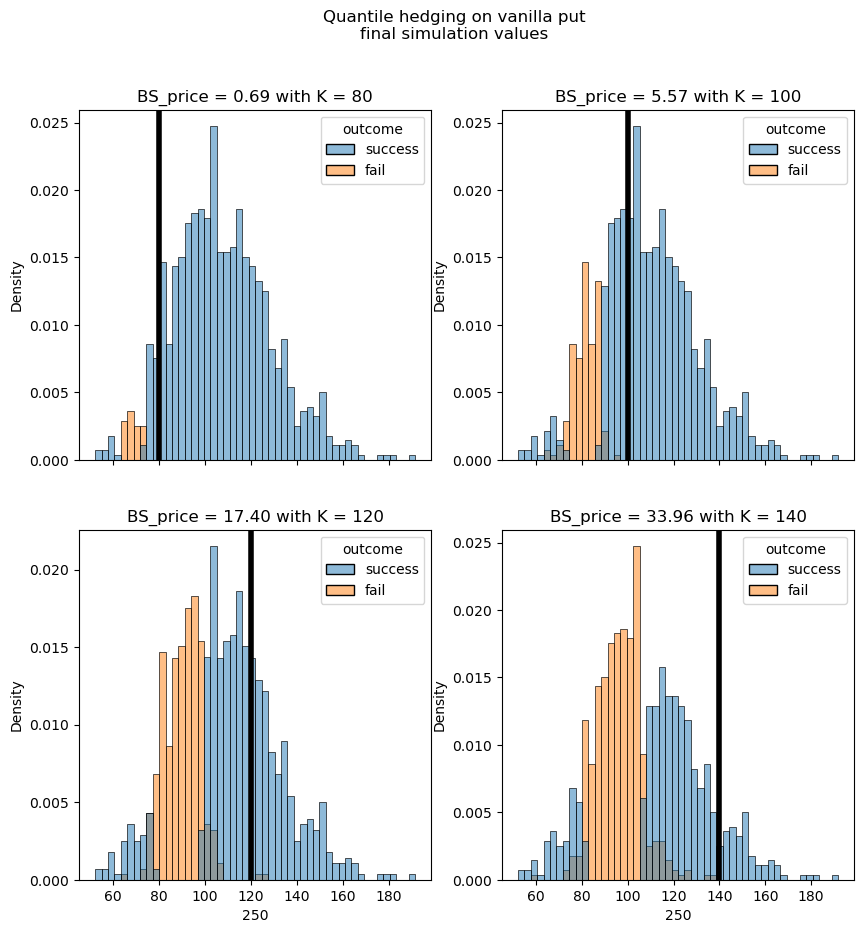

In [57]:
Ks = [80, 100, 120, 140]
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex = True)
for num, K in tqdm(enumerate(Ks)):
    vanilla_put = Vanilla(underlying, K, T, False)
    BS_price = vanilla_put.get_price(X0, 0)
    money_time_put = pd.DataFrame(np.zeros(reality.shape))
    delta_time_put = pd.DataFrame(np.zeros(reality.shape))
    for i in range(repeat):
        trader = Trader(initial_capital = 0.5 * BS_price)
        money, delta, _ = trader.simulate_hedging(vanilla_put, X0*reality.iloc[[i],:], update_freq = 1, limited_capital = True)
        money_time_put.loc[i] = money
        delta_time_put.loc[i] = delta
    money_time_put_outcome = money_time_put.copy()
    money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
    sb.histplot(ax = axs[num//2, num%2], x = (X0*reality)[underlying.values_per_year * T], hue = money_time_put_outcome['outcome'], bins = 50, stat = 'density').set_title(f'BS_price = {BS_price:.2f} with K = {K}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla put\nfinal simulation values')

8it [00:02,  3.72it/s]


Text(0.5, 0.98, 'Quantile hedging on vanilla put\nmodified payoff')

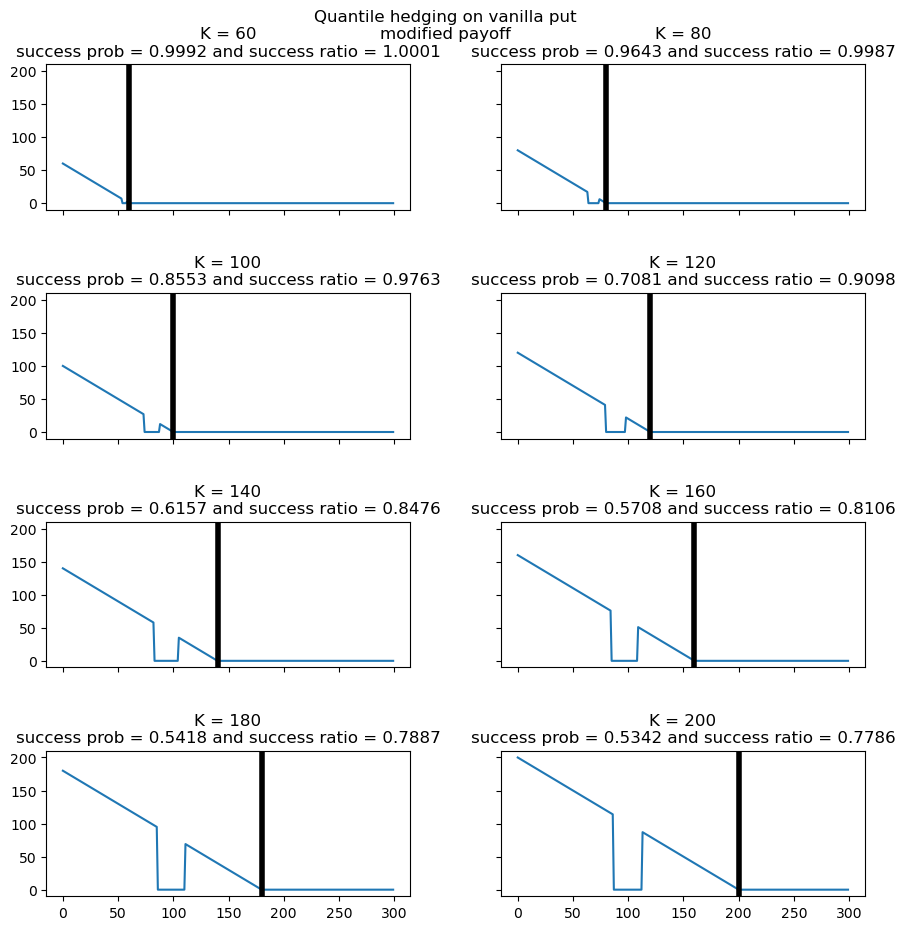

In [58]:
Ks = [60, 80, 100, 120, 140, 160, 180, 200]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex = True, sharey = True)
fig.tight_layout(pad=5.0)
for num, K in tqdm(enumerate(Ks)):
    vanilla_put = Vanilla(underlying, K, T, False)
    BS_price = vanilla_put.get_price(X0, 0)
    V0 = 0.5 * BS_price
    payoff_func, objective_func, _ = payoff_from_v0(vanilla_put, V0, X0)
    axs[num//2, num%2].plot(X, payoff_func(X))
    axs[num//2, num%2].set_title(f'K = {K}\nsuccess prob = {objective_func[0]:.4f} and success ratio = {objective_func[1]:.4f}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla put\nmodified payoff')

8it [00:02,  3.56it/s]


Text(0.5, 0.98, 'Quantile hedging on vanilla put\nmodified payoff')

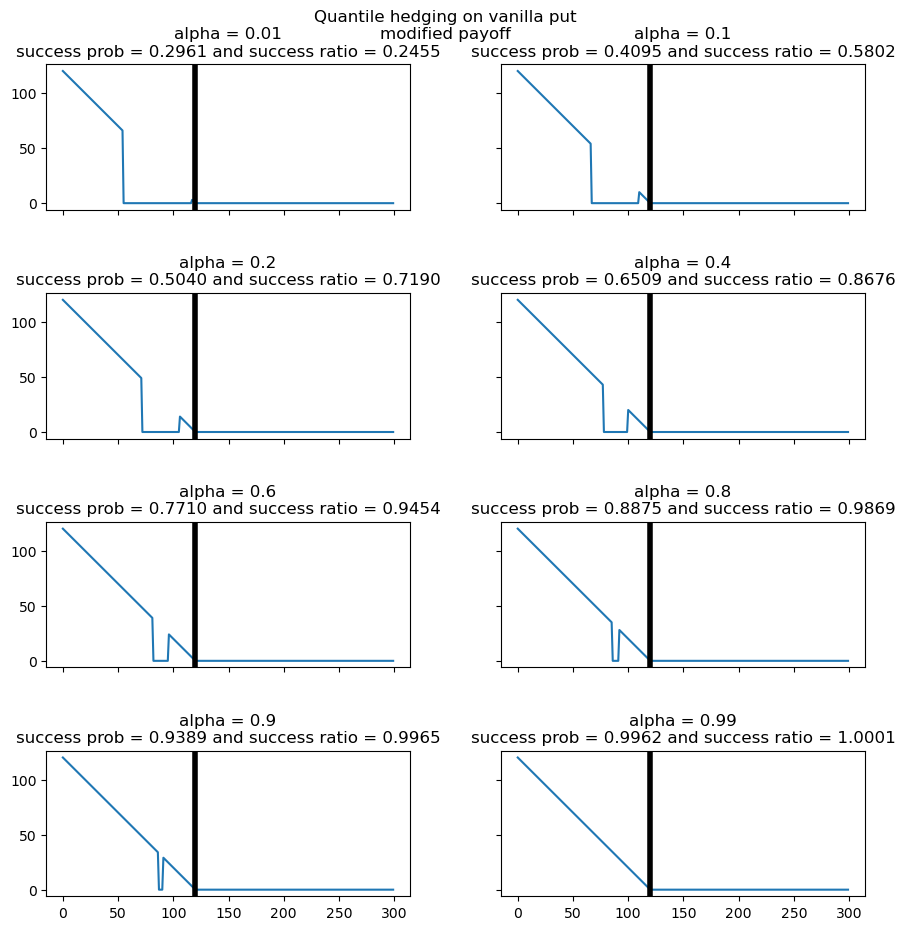

In [59]:
alphas = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex = True, sharey = True)
fig.tight_layout(pad=5.0)
for num, a in tqdm(enumerate(alphas)):
    vanilla_put = Vanilla(underlying, 120, T, False)
    BS_price = vanilla_put.get_price(X0, 0)
    V0 = a * BS_price
    payoff_func, objective_func, _ = payoff_from_v0(vanilla_put, V0, X0)
    axs[num//2, num%2].plot(X, payoff_func(X))
    axs[num//2, num%2].set_title(f'alpha = {a}\nsuccess prob = {objective_func[0]:.4f} and success ratio = {objective_func[1]:.4f}')
    axs[num//2, num%2].axvline(120, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla put\nmodified payoff')

8it [00:02,  3.66it/s]


Text(0.5, 0.98, 'Quantile hedging on vanilla put\nmodified payoff')

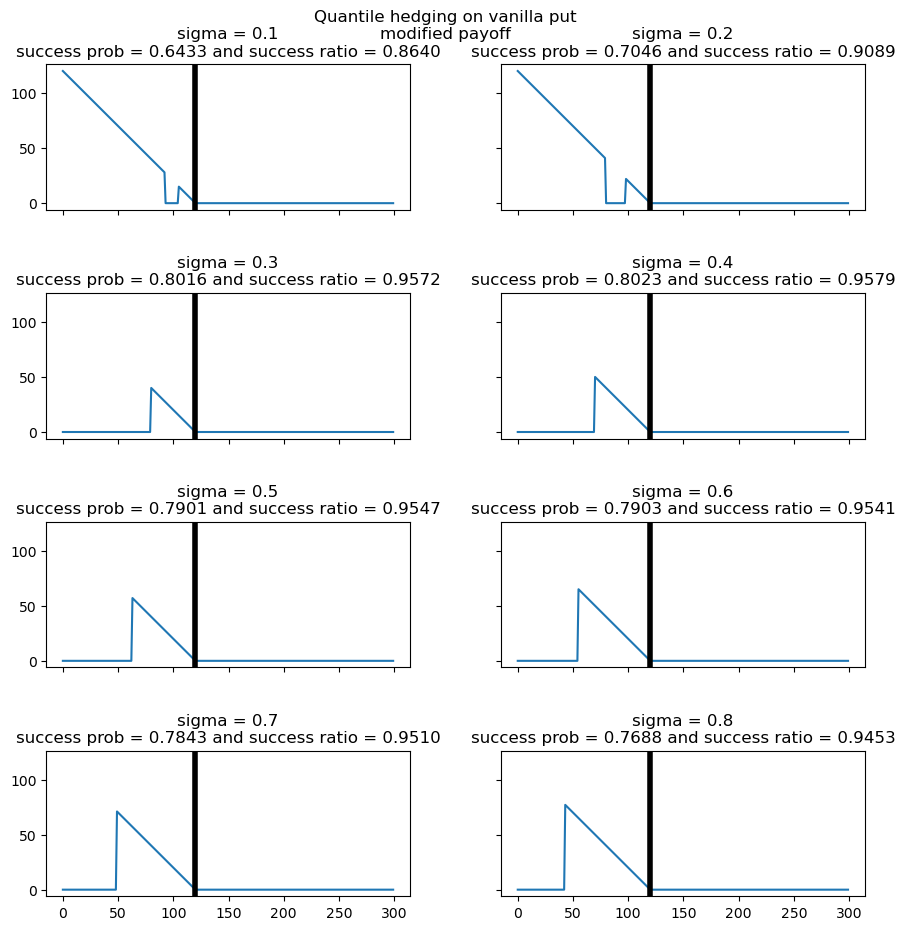

In [62]:
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex = True, sharey = True)
fig.tight_layout(pad=5.0)
for num, s in tqdm(enumerate(sigmas)):
    underlying = Underlying(mu, s, r, values_per_year)
    vanilla_put = Vanilla(underlying, 120, T, False)
    BS_price = vanilla_put.get_price(X0, 0)
    V0 = BS_price / 2
    payoff_func, objective_func, _ = payoff_from_v0(vanilla_put, V0, X0)
    axs[num//2, num%2].plot(X, payoff_func(X))
    axs[num//2, num%2].set_title(f'sigma = {s}\nsuccess prob = {objective_func[0]:.4f} and success ratio = {objective_func[1]:.4f}')
    axs[num//2, num%2].axvline(120, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla put\nmodified payoff')

### Druga Funkcja Celu

Rozpatrzymy teraz drugą funkcję celu

$$ \phi = \mathbb{1}_{\{H \leq V_{T} \}} + \frac{V_{T}}{H} \mathbb{1}_{\{H > V_{T} \}}$$

i naszym celem ponownie będzie optymalizacja jej wartości oczekiwanej $ \left( \mathbb{E}\left[ \phi \right] \right) $.
Publikacja Hansa F \"{o} llmera i Petera Leukerta tym razem także dostarcza rozwiązanie, według którego strategią optymalizującą powyższą wartość jest pełny $\Delta$-hedging opcji o payoffie $\tilde{H} = \tilde{\phi}H$, dla

$$\tilde{\phi} = \mathbb{1}_{\{\frac{dP}{dQ} > \tilde{a} H \}} + \gamma \mathbb{1}_{\{\frac{dP}{dQ} = \tilde{a} H \}},$$
gdzie

$$\gamma = \frac{\alpha - Q^{*} \left[ \frac{dP}{dQ} > \tilde{a}H  \right]}{Q^{*} \left[ \frac{dP}{dQ} = \tilde{a}H  \right]}.$$

Pierwszy indykator funkcji $\tilde{\phi}$ pokrywa sytuacje z pierwszej funkcji celu, tak więc jedyną różnicą jest występowanie drugiego indykatora.

Teza:

W przypadku opcji call i put oraz trajektorii modelowanych geometrycznym ruchem Browna, zbiór $\{\frac{dP}{dQ} = \tilde{a} H \}$ jest zbiorem miary zero.

Dowód:

Z ogólnej teorii inżynierii finansowej, wiemy że pochodna Radona-Nikodyma między domyślną miarą probabilistyczną a miara martyngałową ma postać

$$ \frac{d Q}{d P} =  e^{- \lambda W_{t} - \frac{1}{2} \lambda^{2}t}$$

dla $\lambda = \frac{\mu - r}{\sigma}$, tak więc występująca w naszym zbiorze odwrotność wynosi

$$ \frac{d P}{d Q} =  e^{\lambda W_{t} + \frac{1}{2} \lambda^{2}t}.$$ 

Tym samym rozpatrujemy zbiór trajektorii spełniających równość

$$e^{\lambda W_{T} + \frac{1}{2} \lambda^{2}T} = \tilde{a} \cdot H.$$

Korzystamy w tym miejscu z założenia, że rozpatrujemy opcję call (w przypadku opcji put argument jest analogiczny) i możemy rozpisać payoff $H$ jako:

$$H = \left( S_{T} - K \right)_{+}.$$

Następnie rozpisujemy jawnie wzór na $S_{T}$, co daje

$$H = \left( e^{ \left( \mu - \frac{\sigma^{2}}{2} \right)T + \sigma W_{T}} - K \right)_{+} $$

czym dochodzimy do poniższej postaci równości 

$$ e^{\lambda W_{T} + \frac{1}{2} \lambda^{2}T} = \tilde{a} \cdot \left( e^{ \left( \mu - \frac{\sigma^{2}}{2} \right)T + \sigma W_{T}} - K \right)_{+}.$$

Zauważmy teraz, że możemy pominąć nałożoną po prawej stronie część dodatnią. Lewa strona równości jest funkcją wykładniczą, tak więc zawsze jest dodatnia i tym samym równość nie może zajść w przypadku gdy prawa strona jest zerowa lub ujemna, wobec czego pozwolenie ujemnym przypadkom pozostać ujemnym (zamiast zamieniania ich na 0), nie zmienia zbioru rozwiązań. Mamy tym samym

$$ e^{\lambda W_{T} + \frac{1}{2} \lambda^{2}T} = \tilde{a} \cdot  \left( e^{ \left( \mu - \frac{\sigma^{2}}{2} \right)T + \sigma W_{T}} - K \right).$$

Rozpiszmy teraz $\lambda$

$$ e^{ \left( \frac{\mu - r}{\sigma} \right) W_{T} + \frac{1}{2} \left( \frac{\mu - r}{\sigma} \right)^{2}T} = \tilde{a} \cdot e^{ \left( \mu - \frac{\sigma^{2}}{2} \right)T + \sigma W_{T}} - \tilde{a} \cdot K$$

oraz dla przejrzystości wprowadźmy dwa oznaczenia

$$b_{1} = e^{\frac{1}{2} \left( \frac{\mu - r}{\sigma} \right)^{2}T}\ , \quad b_{2} = e^{\left( \mu - \frac{\sigma^{2}}{2} \right)T}$$

by ostatecznie otrzymać

$$ b_{1} \cdot e^{ \left( \frac{\mu - r}{\sigma} \right) W_{T}} = \tilde{a} \cdot b_{2} \cdot e^{\sigma W_{T}} - \tilde{a} \cdot K.$$

Są teraz trzy możliwe sytuacje:
1. Równanie jest sprzeczne i nie ma rozwiązań, co zadaje zbiór pusty (który jest oczywiście miary zero)

2. Równanie ma jedno lub dwa rozwiązania. Korzystamy teraz jednak z założenia o ciągłości, a mianowicie, ponieważ $W_{T}$ pochodzi z rozkładu normalnego, to dla każdego $x$ mamy $P \left [W_{T} = x \right] = 0 $, co również daje nam zbiór miary zero.

3. Potencjalnie interesowałaby nas więc jedynie ostatnia sytuacja  w której funkcje się (przynajmniej na pewnym przedziale) pokrywają, co zadałoby przedział o niezerowej mierze. Tak się jednak nie dzieje, ponieważ o ile może się zdarzyć, że części wykładnicze są takie same, o tyle prawa strona ma niezerowe przesunięcie. Uzasadnienie:

    Przesuniecie jest zadane przez $\tilde{a} K$. Jeśli $\tilde{a} = 0$, to cała prawa strona równa się $0$, co w obliczu dodatniości lewej strony daje sprzeczność. $K$ natomiast jest parametrem opcji call. Z założenia K > 0, ponieważ w przeciwnym przypadku nie mielibyśmy do czynienia z tym aktywem pochodnym (w przypadku K = 0 opcja dawałaby nam możliwość zakupu aktywa po cenie rynkowej).
    
Co kończy dowód, że $\{\frac{dP}{dQ} = \tilde{a} H \}$ jest miary 0.

Wniosek:

Optymalizacja drugiej funkcji celu jest osiągana przez strategię, którą realizowaliśmy przy pierwszej funkcji celu.